In [88]:
import sys 
sys.path.append('..')
from utils import *
from kernels import *
from distributions import *
from kernelGAN import *
import torch, matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

device = torch.device('cpu')
%matplotlib inline
plt.rcParams.update({'font.size': 20})
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initializing Generated Points with Zero Mean

In [103]:
# distribution params
n_true, n_gen, d = 1, 20, 2
n_mixture = 20
device = torch.device('cpu')
# initializing points
X_true = torch.tensor([[0, 0]], dtype=torch.float32)
p_true = torch.ones(n_true).softmax(-1)
# gen_distr = get_distr('ring', dim=d, n_mixture=n_mixture, std=0, radius=1, device=device)
# X_gen_init, _ = gen_distr.sample_n(n_gen)
# X_gen_init = X_gen_init@torch.diag(torch.Tensor([0.5,0.5]))
m = torch.distributions.MultivariateNormal(torch.zeros(2), torch.diag(torch.Tensor([.1,.2])))
X_gen_init = m.sample((n_gen,))
X_gen_init -= torch.mean(X_gen_init, axis=0)
_, eigvec = torch.linalg.eigh(X_gen_init.T@X_gen_init)
X_gen_init = X_gen_init@eigvec
p_gen = torch.ones(n_gen).softmax(-1)

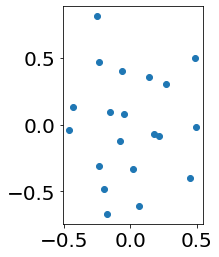

mean: tensor([0., 0.])


In [104]:
plt.scatter(X_gen_init[:,0],X_gen_init[:,1], )
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()
print(f'mean: {X_gen_init.mean(axis=0)}')

### Training Actual Kernel GAN

In [107]:
# initializing discriminator kernel
width_params=[0.5, 1, 2]
# varying across training params
T = 2500
lr_combos = [(1e-2,1e-2)] #[(1e-1,1e-1), (1e-2,1e-2)] #(lr_d,lr_g)
lams = [1, 1e-1, 1e-2]
log_interval=10

W_dist = np.zeros((len(lr_combos), len(lams), len(width_params), T//log_interval))
X_hist = np.zeros((len(lr_combos), len(lams), len(width_params), T, n_gen, d))
for k, width_param in enumerate(width_params):
    # init kernel
    DK = Kernel('gaussian', width_param=width_param)
    for i, (lr_d,lr_g) in enumerate(lr_combos):
        for j, lam in enumerate(lams):
            # init generator + discriminator
            G = NormalGenerator(X_gen_init, p_gen)
            D = KernelDiscriminator(DK,d, lam, lr_d)
            # find generated trajectories
            model = KernelGAN(G, D, device)
            model.train(X_true, p_true, lr_d, lr_g, T, lam)
            # calculate w2 distances
            curr_w2 = wasserstein2(model.G.X_gen.detach().cpu(), X_true.detach().cpu(), log_interval)
            W_dist[i, j, k, :] = curr_w2
            X_hist[i, j, k, :, : , :] = model.G.X_gen.detach().cpu()

100%|██████████| 250/250 [00:00<00:00, 940.80it/s]


In [127]:
rho_hist = np.zeros((len(lr_combos), len(lams), len(width_params), T, d))

for k, width_param in enumerate(tqdm(width_params)):
    gam = 1/(width_param**2)
    for i, (lr_d,lr_g) in enumerate(lr_combos):
        for j, lam in enumerate(lams):
            # first get eigenvalues of init cov. matrix
            Cov = torch.cov(X_gen_init.T)
            rhos,_ = torch.linalg.eigh(Cov)
            rho1, rho2 = rhos[0],rhos[1]
            c1,c2 = 0,0
            for it in range(T):              
                # Quadratic model
                c1 = (1-lam*lr_d)*c1 + 0.5*(lr_d*gam**2)*(3*rho1 + rho2)
                c2 = (1-lam*lr_d)*c2 + 0.5*(lr_d*gam**2)*(rho1 + 3*rho2)
                rho1 = rho1*(1-lr_g*p_gen[0]*c1)**2
                rho2 = rho2*(1-lr_g*p_gen[0]*c2)**2
                rho_hist[i,j,k,it,0] = rho1
                rho_hist[i,j,k,it,1] = rho2

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


## Plotting

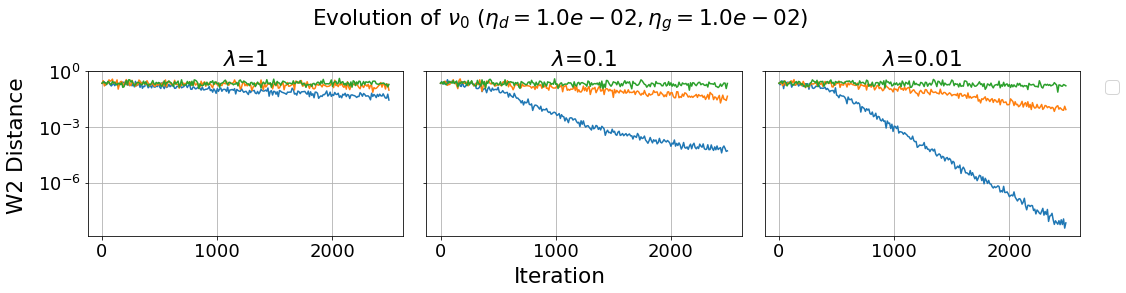

In [108]:
lr_index=0
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,3,figsize=(16,4), sharey=True)
for j, lam in enumerate(lams):
    # curr_ax = ax[j//2,j%2]
    curr_ax =  ax[j]
    curr_ax.set_title(f'$\lambda$={lam}')
    curr_ax.grid()
    for k, width_param in enumerate(width_params):
        curr_ax.semilogy(np.arange(0,T,log_interval), W_dist[lr_index, j, k, :])

ax[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.tight_layout(rect=[0.03, 0.03, 1, 0.90])
fig.supylabel('W2 Distance')
fig.supxlabel('Iteration')
fig.suptitle(f'Evolution of W2 ($\eta_d={lr_combos[lr_index][0]:.1e},\eta_g={lr_combos[lr_index][1]:.1e}$)')
# plt.savefig(f"../data/twopoint_lr{lr_index}_ODEoverlay.png", format='png', bbox_inches='tight')
plt.show()

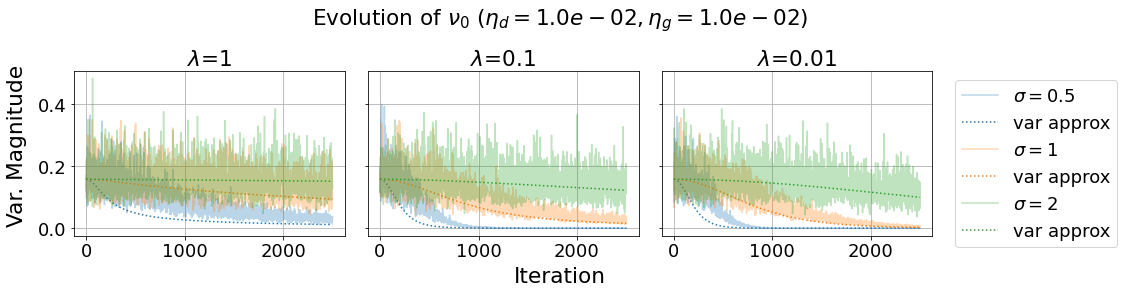

In [128]:
lr_index=0
rho_index = 1
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,3,figsize=(16,4), sharey=True)
for j, lam in enumerate(lams):
    # curr_ax = ax[j//2,j%2]
    curr_ax =  ax[j]
    curr_ax.set_title(f'$\lambda$={lam}')
    curr_ax.grid()
    for k, width_param in enumerate(width_params):
        curr_X_hist = X_hist[lr_index,j, k,:,:,:]
        V_hist = [np.cov(X.T) for X in curr_X_hist]
        tv = [np.trace(X.T@X)/n_gen for X in curr_X_hist]
        rho1s = [np.linalg.eigh(Cov)[0][0] for Cov in V_hist] 
        rho2s = [np.linalg.eigh(Cov)[0][1] for Cov in V_hist] 
        rhos_select = rho1s if rho_index==0 else rho2s
        curr_ax.plot(list(range(0,T)), rhos_select, c=f'C{k}', label=f'$\sigma=${width_param}', alpha=0.3)
        curr_ax.plot(list(range(0,T)), rho_hist[lr_index,j, k,:,rho_index], c=f'C{k}', label=f'var approx', ls='dotted', alpha=1)
        # curr_ax.semilogy(list(range(0,T)), Xhistquad[lr_index,j, k,:]**2, c=f'C{k}', label=f'quadratic', ls='dotted')
        # curr_ax.semilogy(list(range(0,T)), Xhistavg[lr_index,j, k,:]**2, c=f'C{k}', label=f'avg', ls='dashed')
        # curr_ax.set_ylim((10**-14,10**3))
ax[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.tight_layout(rect=[0.03, 0.03, 1, 0.90])
fig.supylabel('Var. Magnitude')
fig.supxlabel('Iteration')
fig.suptitle(f'Evolution of $\\nu_{int(1-rho_index)}$ ($\eta_d={lr_combos[lr_index][0]:.1e},\eta_g={lr_combos[lr_index][1]:.1e}$)')
# plt.savefig(f"../data/twopoint_lr{lr_index}_ODEoverlay.png", format='png', bbox_inches='tight')
plt.show()

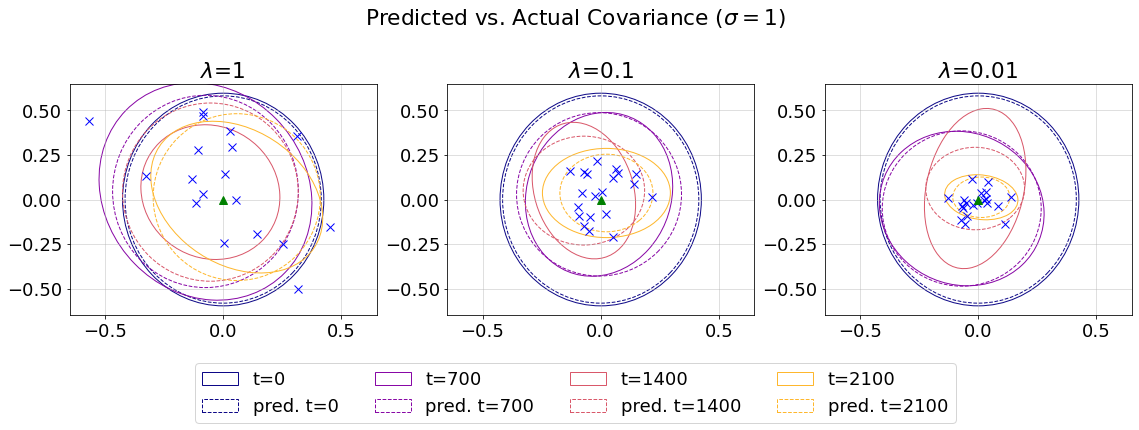

In [124]:
import matplotlib
lr_index=0
rho_index = 1
lim = 0.65
k = 1
width_param = width_params[k]
cmap = matplotlib.cm.get_cmap('plasma')
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,3,figsize=(16,5), tight_layout=True)
for j, lam in enumerate(lams):
    curr_ax =  ax[j]
    curr_ax.set_title(f'$\lambda$={lam}')
    curr_ax.grid(alpha=0.5)
    # for k, width_param in enumerate(width_params):
    curr_X_hist = X_hist[lr_index,j, k,:,:,:]
    for t in range(0,T,700):
        # curr_ax.scatter(curr_X_hist[t,:,0], curr_X_hist[t,:,1])
        confidence_ellipse(curr_X_hist[t,:,0], curr_X_hist[t,:,1], curr_ax, n_std=1.5, edgecolor=cmap(t/T), 
                           label=f't={t}')
        _, eigvec = np.linalg.eigh((X_gen_init.T@X_gen_init)/n_gen)
        Cov_predicted = eigvec@np.diag(rho_hist[lr_index,j, k,t,:])@eigvec.T
        confidence_ellipse(curr_X_hist[t,:,0], curr_X_hist[t,:,1], curr_ax, cov=Cov_predicted, n_std=1.5, 
                           edgecolor=cmap(t/T), ls='dashed', label=f'pred. t={t}')
        curr_ax.set_xlim(-lim,lim); curr_ax.set_ylim(-lim,lim)
    for gen_idx in range(n_gen):
        # curr_ax.plot(curr_X_hist[:,gen_idx,0],curr_X_hist[:,gen_idx,1], ls='-', c='r', marker='o', ms=3, markevery=500)
        curr_ax.plot(curr_X_hist[-1,gen_idx,0],curr_X_hist[-1,gen_idx,1], c='b', marker='x', ms=8, linewidth=10)
    curr_ax.plot(0,0, c='g', marker='^', ms=8, linewidth=10)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(labels=labels, loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4)
# fig.suptitle(f'$\eta_d=\eta_g=${lr_combos[0][0]:.1e}')
fig.suptitle(f'Predicted vs. Actual Covariance ($\sigma=${width_params[k]})')
plt.show()

### Individual Runs

In [138]:
T=1000
lam=0.01
lr_d, lr_g = 1e-2, 1e-2

# init generator + discriminator
DK = Kernel('gaussian', width_param=0.25)
# DK = Kernel('laplacian', width_param=10)
# DK = Kernel('rq', width_param=5, mix_param=0.5)
G = NormalGenerator(X_gen_init, p_gen)
D = KernelDiscriminator(DK,d, lam, lr_d)
# find generated trajectories
model = KernelGAN(G, D, device)
model.train(X_true, p_true, lr_d, lr_g, T, lam)
curr_w2 = wasserstein2(model.G.X_gen.detach().cpu(), X_true.detach().cpu(), log_interval)

100%|██████████| 100/100 [00:00<00:00, 1211.75it/s]


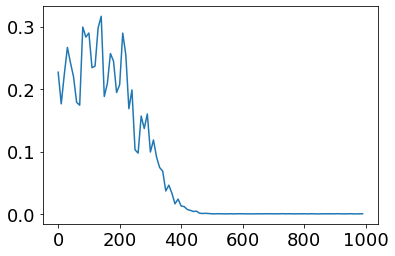

In [139]:
plt.plot(np.arange(0,T,log_interval), curr_w2)

In [141]:
# animate the generated point trajectories
lim=1.2
figure, axes = plt.subplots(figsize=(8,5)) 
camera = Camera(figure)

# plot initial distribution
plt.scatter(X_true[0,0],X_true[0,1],c='r', label='true', marker='*')
# plt.scatter(X_true[:,0],X_true[:,1],c='w', edgecolor='b',alpha=.5)
plt.xlim([-lim,lim]); plt.ylim([-lim,lim])
scat=plt.scatter(model.G.X_gen[0,:,0],model.G.X_gen[0,:,1],c='g', label='gen')
plt.legend(loc='upper right')

# updating generated points
plt_interval = 20
for i, sample_idx in enumerate(range(0,T, plt_interval)): 
    x0, x1, u, v = model.get_grad_field(sample_idx-1, xlim=[-lim,lim], ylim=[-lim,lim], nplt=20)
    plt.quiver(x0,x1,u,v)
    plt.scatter(X_true[:,0],X_true[:,1],c='r', label='true', marker='*')
    plt.scatter(model.G.X_gen[sample_idx,:,0], model.G.X_gen[sample_idx,:,1], c='g', label='gen')
    camera.snap()

plt.close()
anim = camera.animate()
HTML(anim.to_html5_video())